In [1]:
import duckdb

import pandas as pd
import numpy as np
import geopandas as gpd
import shapely

import random
import json

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

In [25]:
sns.set_context('paper')
sns.set_theme()
sns.set_style('white')

In [3]:
def get_trip_colors(n_colors):
    og_colors = list(mcolors.TABLEAU_COLORS.values())
    while len(og_colors) < n_colors:
        og_colors = og_colors * 2
    return random.sample(og_colors, n_colors)

In [5]:
connection = duckdb.connect(
    database='./databases/berlinmod.db',
    config={'allow_unsigned_extensions' : 'true'}
)

connection.load_extension('~/duckdb/mobilityduck/build/release/extension/mobilityduck/mobilityduck.duckdb_extension')
connection.load_extension('spatial');

[mobilityduck] Using SRID CSV: /home/ubuntu/duckdb/mobilityduck/build/release/vcpkg_installed/arm64-linux/share/spatial_ref_sys.csv


In [74]:
connection.close()

## Create table and load data from CSV

In [6]:
query = """
CREATE OR REPLACE TABLE trips (
    tripid INTEGER,
    vehicleid INTEGER,
    posx DOUBLE,
    posy DOUBLE,
    t TIMESTAMPTZ
);
"""
connection.execute(query)

In [7]:
query = "COPY trips FROM 'data/trips.csv';"
connection.execute(query)

In [8]:
query = "SELECT COUNT(*) FROM trips;"
result = connection.execute(query).fetchone()
result


(2341801,)

In [9]:
query = "SELECT * FROM trips LIMIT 5;"
result = connection.execute(query).df()
result

tripid  vehicleid        posx       posy                                t
0       1          1  105.680333  21.107531 2020-06-01 09:21:03.543000+00:00
1       1          1  105.680294  21.107512 2020-06-01 09:21:05.043000+00:00
2       1          1  105.680254  21.107493 2020-06-01 09:21:05.793000+00:00
3       1          1  105.680014  21.107377 2020-06-01 09:21:09.393000+00:00
4       1          1  105.680014  21.107377 2020-06-01 09:21:10.169623+00:00

In [10]:
query = """
CREATE OR REPLACE TABLE trajectories(
    tripid integer PRIMARY KEY,
    vehicleid integer NOT NULL,
    trip tgeompoint NOT NULL,
    traj geometry
);

CREATE OR REPLACE TABLE traj_temp (
    tripid integer NOT NULL,
    vehicleid integer NOT NULL,
    tgeom tgeompoint[] NOT NULL
);

INSERT INTO traj_temp(tripid, vehicleid, tgeom)
SELECT tripid, vehicleid,
    array_agg(
        tgeompoint(
        ST_Transform(
            ST_Point(PosX, PosY),
            'EPSG:4326',
            'EPSG:3857',
            always_xy := true
        )::WKB_BLOB, t
        )
        ORDER BY t
    )
FROM trips
GROUP BY vehicleid, tripid
ORDER BY vehicleid, tripid;

INSERT INTO trajectories(tripid, vehicleid, trip)
SELECT tripid, vehicleid, tgeompointSeq(tgeom) FROM traj_temp;

UPDATE trajectories
SET traj = trajectory(trip)::GEOMETRY;
"""

connection.execute(query)

In [11]:
query = "SELECT asText(trip) as trip, ST_AsText(traj) as traj FROM trajectories LIMIT 5;"
connection.execute(query).df().head()

trip  \
0  [POINT(11764280.900951382 2404705.174917868)@2...   
1  [POINT(11761565.885362627 2389119.1866996125)@...   
2  [POINT(11764280.900951382 2404705.174917868)@2...   
3  [POINT(11762296.419520957 2406852.2928497843)@...   
4  [POINT(11746067.985854387 2405922.9453527434)@...   

                                                traj  
0  LINESTRING (11764280.900951382 2404705.1749178...  
1  LINESTRING (11761565.885362627 2389119.1866996...  
2  LINESTRING (11764280.900951382 2404705.1749178...  
3  LINESTRING (11762296.419520957 2406852.2928497...  
4  LINESTRING (11746067.985854387 2405922.9453527...

## Load municipalities of Hanoi into DuckDB

In [12]:
query = """
CREATE OR REPLACE TABLE hanoi(
    municipalityid BIGINT PRIMARY KEY,
    municipalityname VARCHAR,
    population BIGINT,
    percpop DOUBLE,
    popdensitykm2 BIGINT,
    noenterp BIGINT,
    percenterp DOUBLE,
    municipalitygeo VARCHAR,
    geom GEOMETRY
);

COPY hanoi(municipalityid, municipalityname, population,
    percpop, popdensitykm2, noenterp, percenterp, municipalitygeo)
FROM 'data/municipalities.csv' (DELIMITER ',', HEADER);

UPDATE hanoi
SET geom = ST_GeomFromHEXWKB(municipalitygeo);
"""

connection.execute(query)

In [13]:
query = "SELECT * FROM hanoi;"

hanoi = connection.execute(query).df()
hanoi.head(2)

municipalityid  municipalityname  population  percpop  popdensitykm2  \
0               1      Quận Ba Đình      223100     0.03          24224   
1               2  Quận Bắc Từ Liêm      359200     0.04           7938   

   noenterp  percenterp                                    municipalitygeo  \
0      3981        0.03  0103000020110F0000010000009601000055AD2419DB76...   
1      6409        0.05  0103000020110F0000010000003A01000049B8A0504872...   

                                                geom  
0  [2, 4, 0, 0, 0, 0, 0, 0, 216, 182, 51, 75, 213...  
1  [2, 4, 0, 0, 0, 0, 0, 0, 66, 146, 51, 75, 221,...

In [14]:
hanoi['geom_obj'] = hanoi['municipalitygeo'].apply(lambda x: shapely.wkb.loads(x))
hanoi_gdf = gpd.GeoDataFrame(hanoi, geometry='geom_obj')
hanoi_gdf['color'] = sns.color_palette('hls', hanoi_gdf.shape[0]).as_hex()
hanoi_gdf.head(2)

municipalityid  municipalityname  population  percpop  popdensitykm2  \
0               1      Quận Ba Đình      223100     0.03          24224   
1               2  Quận Bắc Từ Liêm      359200     0.04           7938   

   noenterp  percenterp                                    municipalitygeo  \
0      3981        0.03  0103000020110F0000010000009601000055AD2419DB76...   
1      6409        0.05  0103000020110F0000010000003A01000049B8A0504872...   

                                                geom  \
0  [2, 4, 0, 0, 0, 0, 0, 0, 216, 182, 51, 75, 213...   
1  [2, 4, 0, 0, 0, 0, 0, 0, 66, 146, 51, 75, 221,...   

                                            geom_obj    color  
0  POLYGON ((11777752.786 2395483.963, 11777961.3...  #db5f57  
1  POLYGON ((11768386.52 2400374.69, 11768448.424...  #db7957

In [70]:
query = "SELECT ST_AsText(traj) as traj FROM trajectories;"
trajs = connection.execute(query).df()
trajs['geom_obj'] = trajs['traj'].apply(lambda x: shapely.wkt.loads(x))
trajs_gdf = gpd.GeoDataFrame(trajs, geometry='geom_obj')
trajs_gdf['color'] = 'crimson'
trajs_gdf.head(2)

traj  \
0  LINESTRING (11764280.900951382 2404705.1749178...   
1  LINESTRING (11761565.885362627 2389119.1866996...   

                                            geom_obj    color  
0  LINESTRING (11764280.901 2404705.175, 11764276...  crimson  
1  LINESTRING (11761565.885 2389119.187, 11761570...  crimson

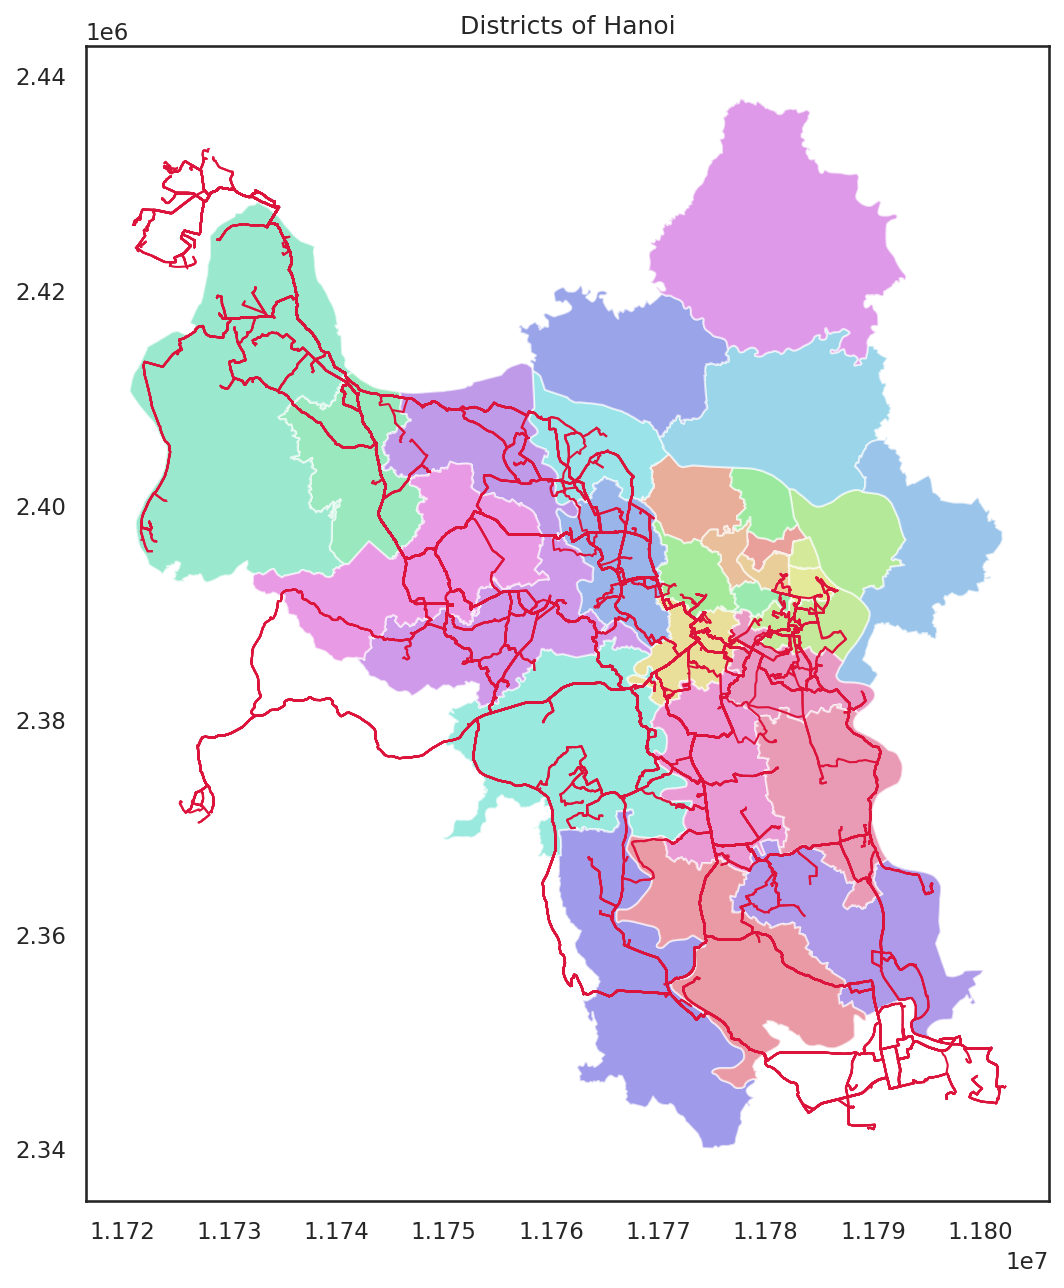

In [71]:
_, axes = plt.subplots(figsize=(10, 10), dpi=150)
hanoi_gdf.plot(color=hanoi_gdf["color"], ax=axes, alpha=0.6)
trajs_gdf.plot(color=trajs_gdf["color"], ax=axes, linewidth=1)

axes.set_title("Districts of Hanoi")

plt.show()

## Sort trips by number of districts intersected

In [28]:
query = """
SELECT vehicleid, tripid,
    COUNT(DISTINCT h.municipalityid) AS intersect_count,
    ST_AsText(traj.traj) AS trajectory
FROM trajectories traj, hanoi h
WHERE ST_Intersects(traj.traj, h.geom)
GROUP BY vehicleid, tripid, ST_AsText(traj.traj)
ORDER BY intersect_count DESC;
"""

intersect_count_df = connection.execute(query).df()
intersect_count_df['geom_obj'] = intersect_count_df['trajectory'].apply(lambda x: shapely.wkt.loads(x))
intersect_count_gdf = gpd.GeoDataFrame(intersect_count_df, geometry='geom_obj')
intersect_count_gdf

vehicleid  tripid  intersect_count  \
0           30     254               12   
1           30     252               12   
2           30     248               12   
3           55     472               11   
4           57     492               11   
..         ...     ...              ...   
508         10      77                1   
509         11      85                1   
510         11      94                1   
511         15     128                1   
512         53     458                1   

                                            trajectory  \
0    LINESTRING (11781160.609298838 2389568.2734171...   
1    LINESTRING (11781160.609298838 2389568.2734171...   
2    LINESTRING (11781160.609298838 2389568.2734171...   
3    LINESTRING (11795472.277181236 2364690.8363631...   
4    LINESTRING (11789714.220860206 2368408.4693026...   
..                                                 ...   
508  LINESTRING (11734270.858289773 2417554.9573414...   
509  LINESTRING (11722622.197530033 2398461.8046262...   
510  LINESTRING (11732463.141078785 2420328.2397976...   
511  LINESTRING (11766232.309361089 2399645.7804065...   
512  LINESTRING (11787061.377207063 2370068.4542036...   

                                              geom_obj  
0    LINESTRING (11781160.609 2389568.273, 11781162...  
1    LINESTRING (11781160.609 2389568.273, 11781162...  
2    LINESTRING (11781160.609 2389568.273, 11781162...  
3    LINESTRING (11795472.277 2364690.836, 11795474...  
4    LINESTRING (11789714.221 2368408.469, 11789709...  
..                                                 ...  
508  LINESTRING (11734270.858 2417554.957, 11734267...  
509  LINESTRING (11722622.198 2398461.805, 11722617...  
510  LINESTRING (11732463.141 2420328.24, 11732460....  
511  LINESTRING (11766232.309 2399645.78, 11766236....  
512  LINESTRING (11787061.377 2370068.454, 11787061...  

[513 rows x 5 columns]

/home/ubuntu/.local/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



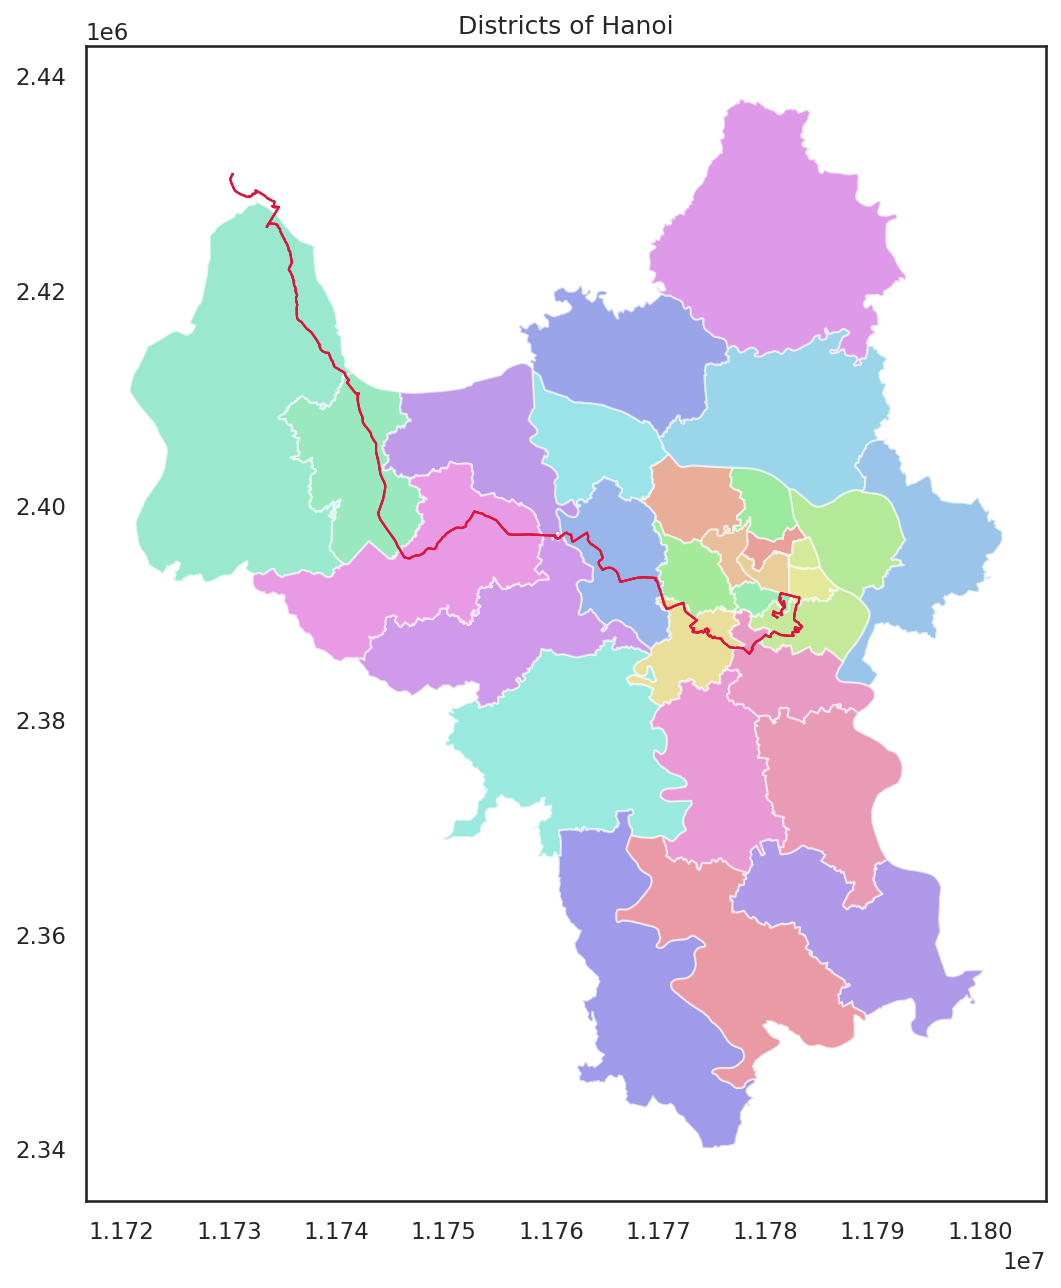

In [72]:
_, axes = plt.subplots(figsize=(10, 10), dpi=150)
hanoi_gdf.plot(color=hanoi_gdf["color"], ax=axes, alpha=0.6)

axes.set_title("Districts of Hanoi")

trips_plot = intersect_count_gdf[intersect_count_gdf['intersect_count'] == intersect_count_gdf['intersect_count'].max()]
trips_plot['color'] = 'crimson'
trips_plot.plot(ax=axes, color=trips_plot['color'], linewidth=1)

plt.show()

## Trips crossing Hai Ba Trung

### All trips that cross Hai Ba Trung

In [31]:
query = """
SELECT vehicleid, tripid, ST_AsText(traj) AS traj
FROM trajectories t, hanoi h
WHERE ST_Intersects(t.traj, h.geom)
    AND h.municipalityname = 'Quận Hai Bà Trưng';
"""

trips_hbt_df = connection.execute(query).df()
trips_hbt_df['geom'] = trips_hbt_df['traj'].apply(lambda x: shapely.wkt.loads(x))
trips_hbt_gdf = gpd.GeoDataFrame(trips_hbt_df, geometry='geom')
trips_hbt_gdf.head()

vehicleid  tripid                                               traj  \
0          5      37  LINESTRING (11756592.709375337 2403942.1525703...   
1          5      38  LINESTRING (11782018.09220447 2393554.89742376...   
2          5      39  LINESTRING (11756592.709375337 2403942.1525703...   
3          5      40  LINESTRING (11782018.09220447 2393554.89742376...   
4          5      41  LINESTRING (11756592.709375337 2403942.1525703...   

                                                geom  
0  LINESTRING (11756592.709 2403942.153, 11756587...  
1  LINESTRING (11782018.092 2393554.897, 11782016...  
2  LINESTRING (11756592.709 2403942.153, 11756587...  
3  LINESTRING (11782018.092 2393554.897, 11782016...  
4  LINESTRING (11756592.709 2403942.153, 11756587...

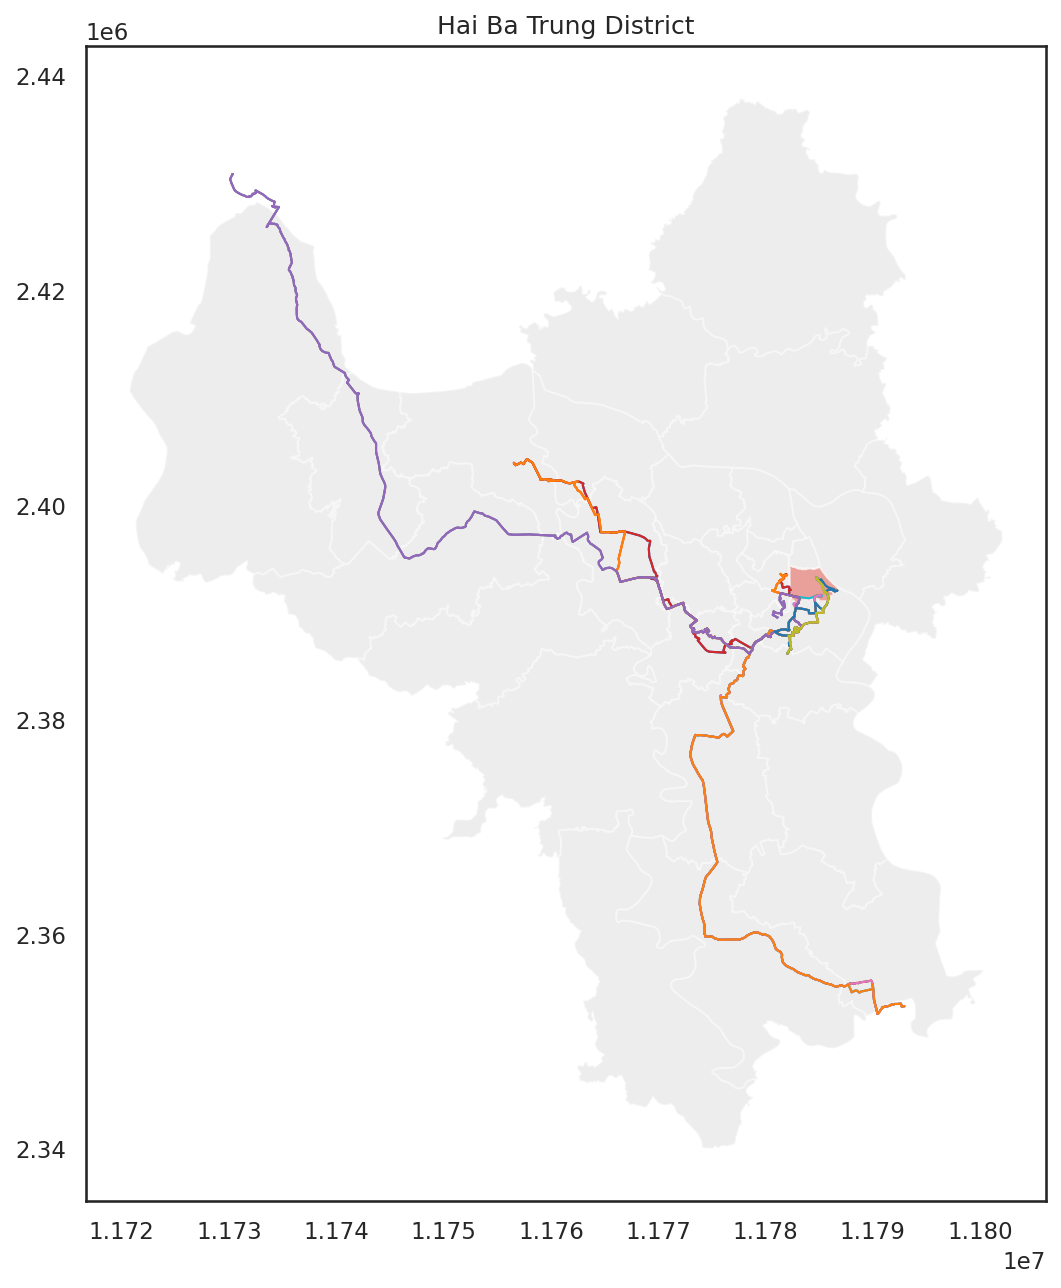

In [60]:
_, axes = plt.subplots(figsize=(10, 10), dpi=150)
hbt_gdf = hanoi_gdf[hanoi_gdf['municipalityname'] == 'Quận Hai Bà Trưng']
not_hbt_gdf = hanoi_gdf[hanoi_gdf['municipalityname'] != 'Quận Hai Bà Trưng']
hbt_gdf.plot(color=hanoi_gdf["color"], ax=axes, alpha=0.6)
not_hbt_gdf.plot(color='lightgrey', ax=axes, alpha=0.4)

axes.set_title("Hai Ba Trung District")

trips_hbt_gdf['color'] = get_trip_colors(trips_hbt_gdf.shape[0])
trips_hbt_gdf.plot(ax=axes, color=trips_hbt_gdf['color'], linewidth=1)

plt.show()

### Parts of trips within Hai Ba Trung

In [33]:
query = """
SELECT vehicleid, tripid,
    trajectory(atGeometry(t.trip, h.geom::WKB_BLOB)) as traj_clip,
    length(atGeometry(t.trip, h.geom::WKB_BLOB)) as overlap_length
FROM trajectories t, hanoi h
WHERE ST_Intersects(t.traj, h.geom)
    AND h.municipalityname = 'Quận Hai Bà Trưng';
"""

trips_hbt_clip_df = connection.execute(query).df()
trips_hbt_clip_df['geom_clip'] = trips_hbt_clip_df['traj_clip'].apply(lambda x: shapely.wkt.loads(x))
trips_hbt_clip_gdf = gpd.GeoDataFrame(trips_hbt_clip_df, geometry='geom_clip')
trips_hbt_clip_gdf.head()

vehicleid  tripid                                          traj_clip  \
0          5      37  MULTILINESTRING((11782977.077909399 2390792.79...   
1          5      38  LINESTRING(11782353.535565963 2391557.74323098...   
2          5      39  MULTILINESTRING((11782977.077909399 2390792.79...   
3          5      40  LINESTRING(11782353.535565963 2391557.74323098...   
4          5      41  MULTILINESTRING((11782977.077909399 2390792.79...   

   overlap_length                                          geom_clip  
0     2242.681473  MULTILINESTRING ((11782977.078 2390792.79, 117...  
1     1467.026673  LINESTRING (11782353.536 2391557.743, 11782357...  
2     2242.681460  MULTILINESTRING ((11782977.078 2390792.79, 117...  
3     1467.026675  LINESTRING (11782353.536 2391557.743, 11782357...  
4     2242.681460  MULTILINESTRING ((11782977.078 2390792.79, 117...

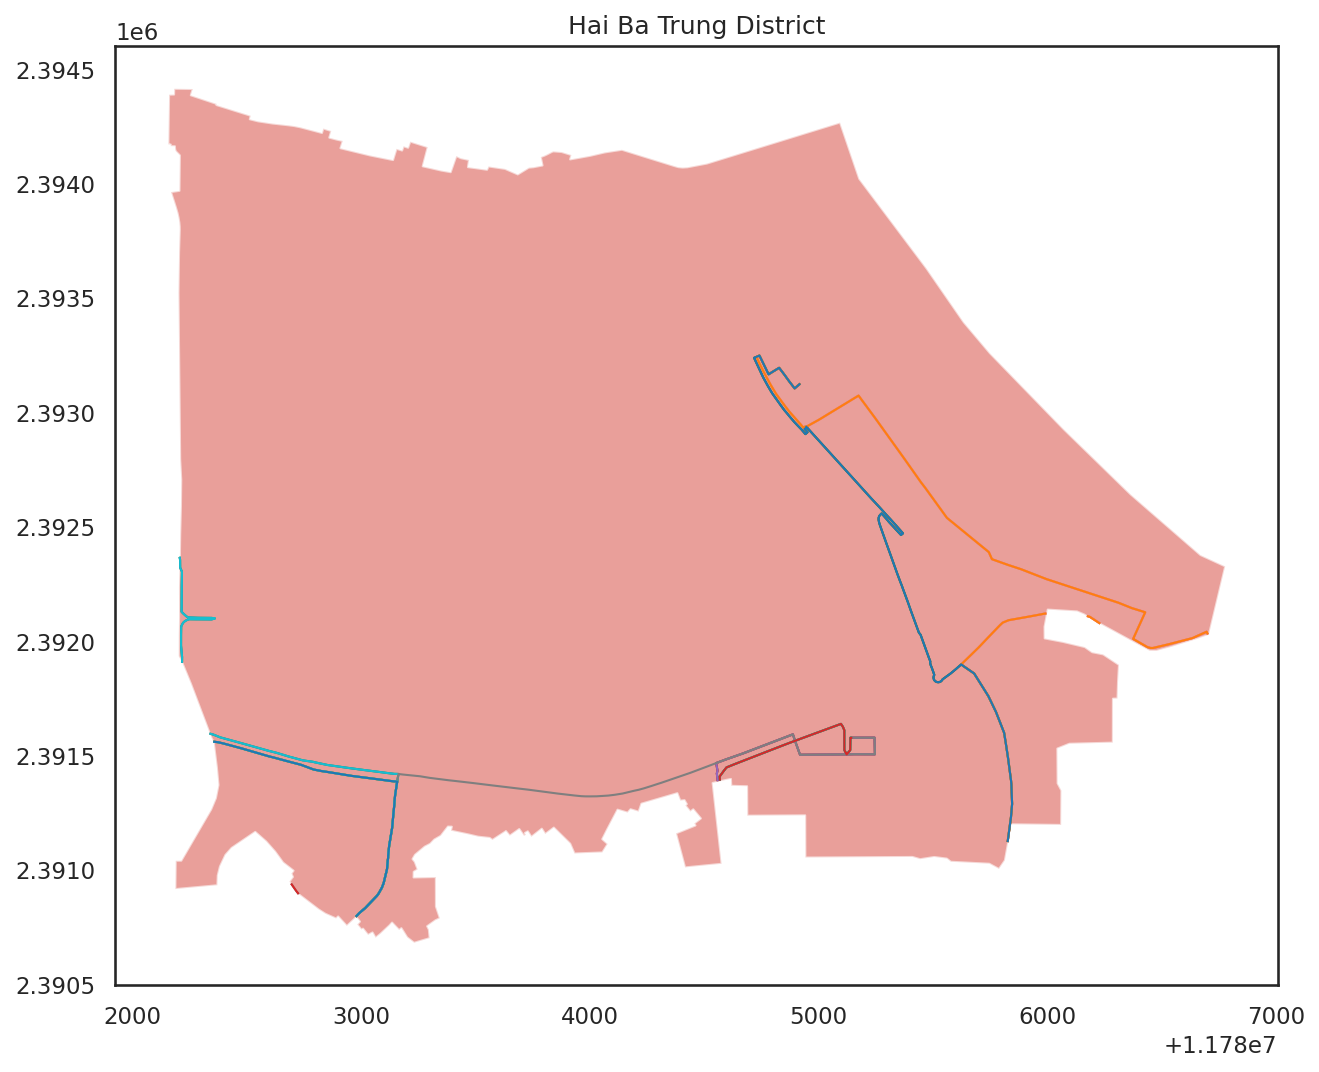

In [34]:
_, axes = plt.subplots(figsize=(10, 10), dpi=150)
hbt_gdf.plot(color=hanoi_gdf["color"], ax=axes, alpha=0.6)

axes.set_title("Hai Ba Trung District")

trips_hbt_clip_gdf['color'] = get_trip_colors(trips_hbt_clip_gdf.shape[0])
trips_hbt_clip_gdf.plot(ax=axes, color=trips_hbt_clip_gdf['color'], linewidth=1)

plt.show()

In [35]:
hbt_px = trips_hbt_clip_gdf.copy()

In [36]:
hbt_px = hbt_px.set_crs('epsg:3857')
hbt_px = hbt_px.to_crs('epsg:4326')

In [37]:
lats = []
lons = []
trip_ids = []

for feature, id in zip(hbt_px['geom_clip'], hbt_px['tripid']):
    if isinstance(feature, shapely.geometry.linestring.LineString):
        linestrings = [feature]
    elif isinstance(feature, shapely.geometry.multilinestring.MultiLineString):
        linestrings = feature.geoms
    else:
        continue
    for linestring in linestrings:
        x, y = linestring.xy
        lats = np.append(lats, y)
        lons = np.append(lons, x)
        trip_ids = np.append(trip_ids, [id] * len(y))
        lats = np.append(lats, None)
        lons = np.append(lons, None)
        trip_ids = np.append(trip_ids, None)

fig = px.line_map(lat=lats, lon=lons, hover_name=trip_ids,
                     map_style="carto-darkmatter", zoom=12)
fig.update_layout(margin={'r': 0, 't': 0, 'l': 0, 'b': 0})

fig.show(renderer="notebook")

## Trips crossing each district

In [38]:
query = """
select municipalityid, municipalityname,
  COUNT(*) as intersect_count
from trajectories traj, hanoi h
where ST_Intersects(traj.traj, h.geom)
group by municipalityid, municipalityname
order by intersect_count desc;
"""

district_count_df = connection.execute(query).df()
print(district_count_df.shape)
district_count_df.head()

(20, 3)


municipalityid municipalityname  intersect_count
0               5     Quận Hà Đông              177
1              24   Huyện Quốc Oai              176
2              27  Huyện Thanh Oai              172
3              14      Huyện Ba Vì              170
4              13   Thị xã Sơn Tây              154

In [39]:
def get_district_trips(district_name):
    query = f"""
SELECT trajectory(atGeometry(t.trip, h.geom::WKB_BLOB)) as traj_clip,
FROM trajectories t, hanoi h
WHERE ST_Intersects(t.traj, h.geom)
    AND h.municipalityname = '{district_name}';
"""
    df = connection.execute(query).df()
    df['geom'] = df['traj_clip'].apply(lambda x: shapely.wkt.loads(x))
    gdf = gpd.GeoDataFrame(df, geometry='geom')
    return gdf

In [40]:
query = """
SELECT ST_AsText(traj) AS traj FROM trajectories;
"""

all_trips_df = connection.execute(query).df()
all_trips_df['geom'] = all_trips_df['traj'].apply(lambda x: shapely.wkt.loads(x))
all_trips_gdf = gpd.GeoDataFrame(all_trips_df, geometry='geom')
all_trips_gdf['color'] = get_trip_colors(all_trips_gdf.shape[0])
all_trips_gdf.head()

traj  \
0  LINESTRING (11764280.900951382 2404705.1749178...   
1  LINESTRING (11761565.885362627 2389119.1866996...   
2  LINESTRING (11764280.900951382 2404705.1749178...   
3  LINESTRING (11762296.419520957 2406852.2928497...   
4  LINESTRING (11746067.985854387 2405922.9453527...   

                                                geom    color  
0  LINESTRING (11764280.901 2404705.175, 11764276...  #e377c2  
1  LINESTRING (11761565.885 2389119.187, 11761570...  #bcbd22  
2  LINESTRING (11764280.901 2404705.175, 11764276...  #2ca02c  
3  LINESTRING (11762296.42 2406852.293, 11762292....  #bcbd22  
4  LINESTRING (11746067.986 2405922.945, 11746063...  #1f77b4

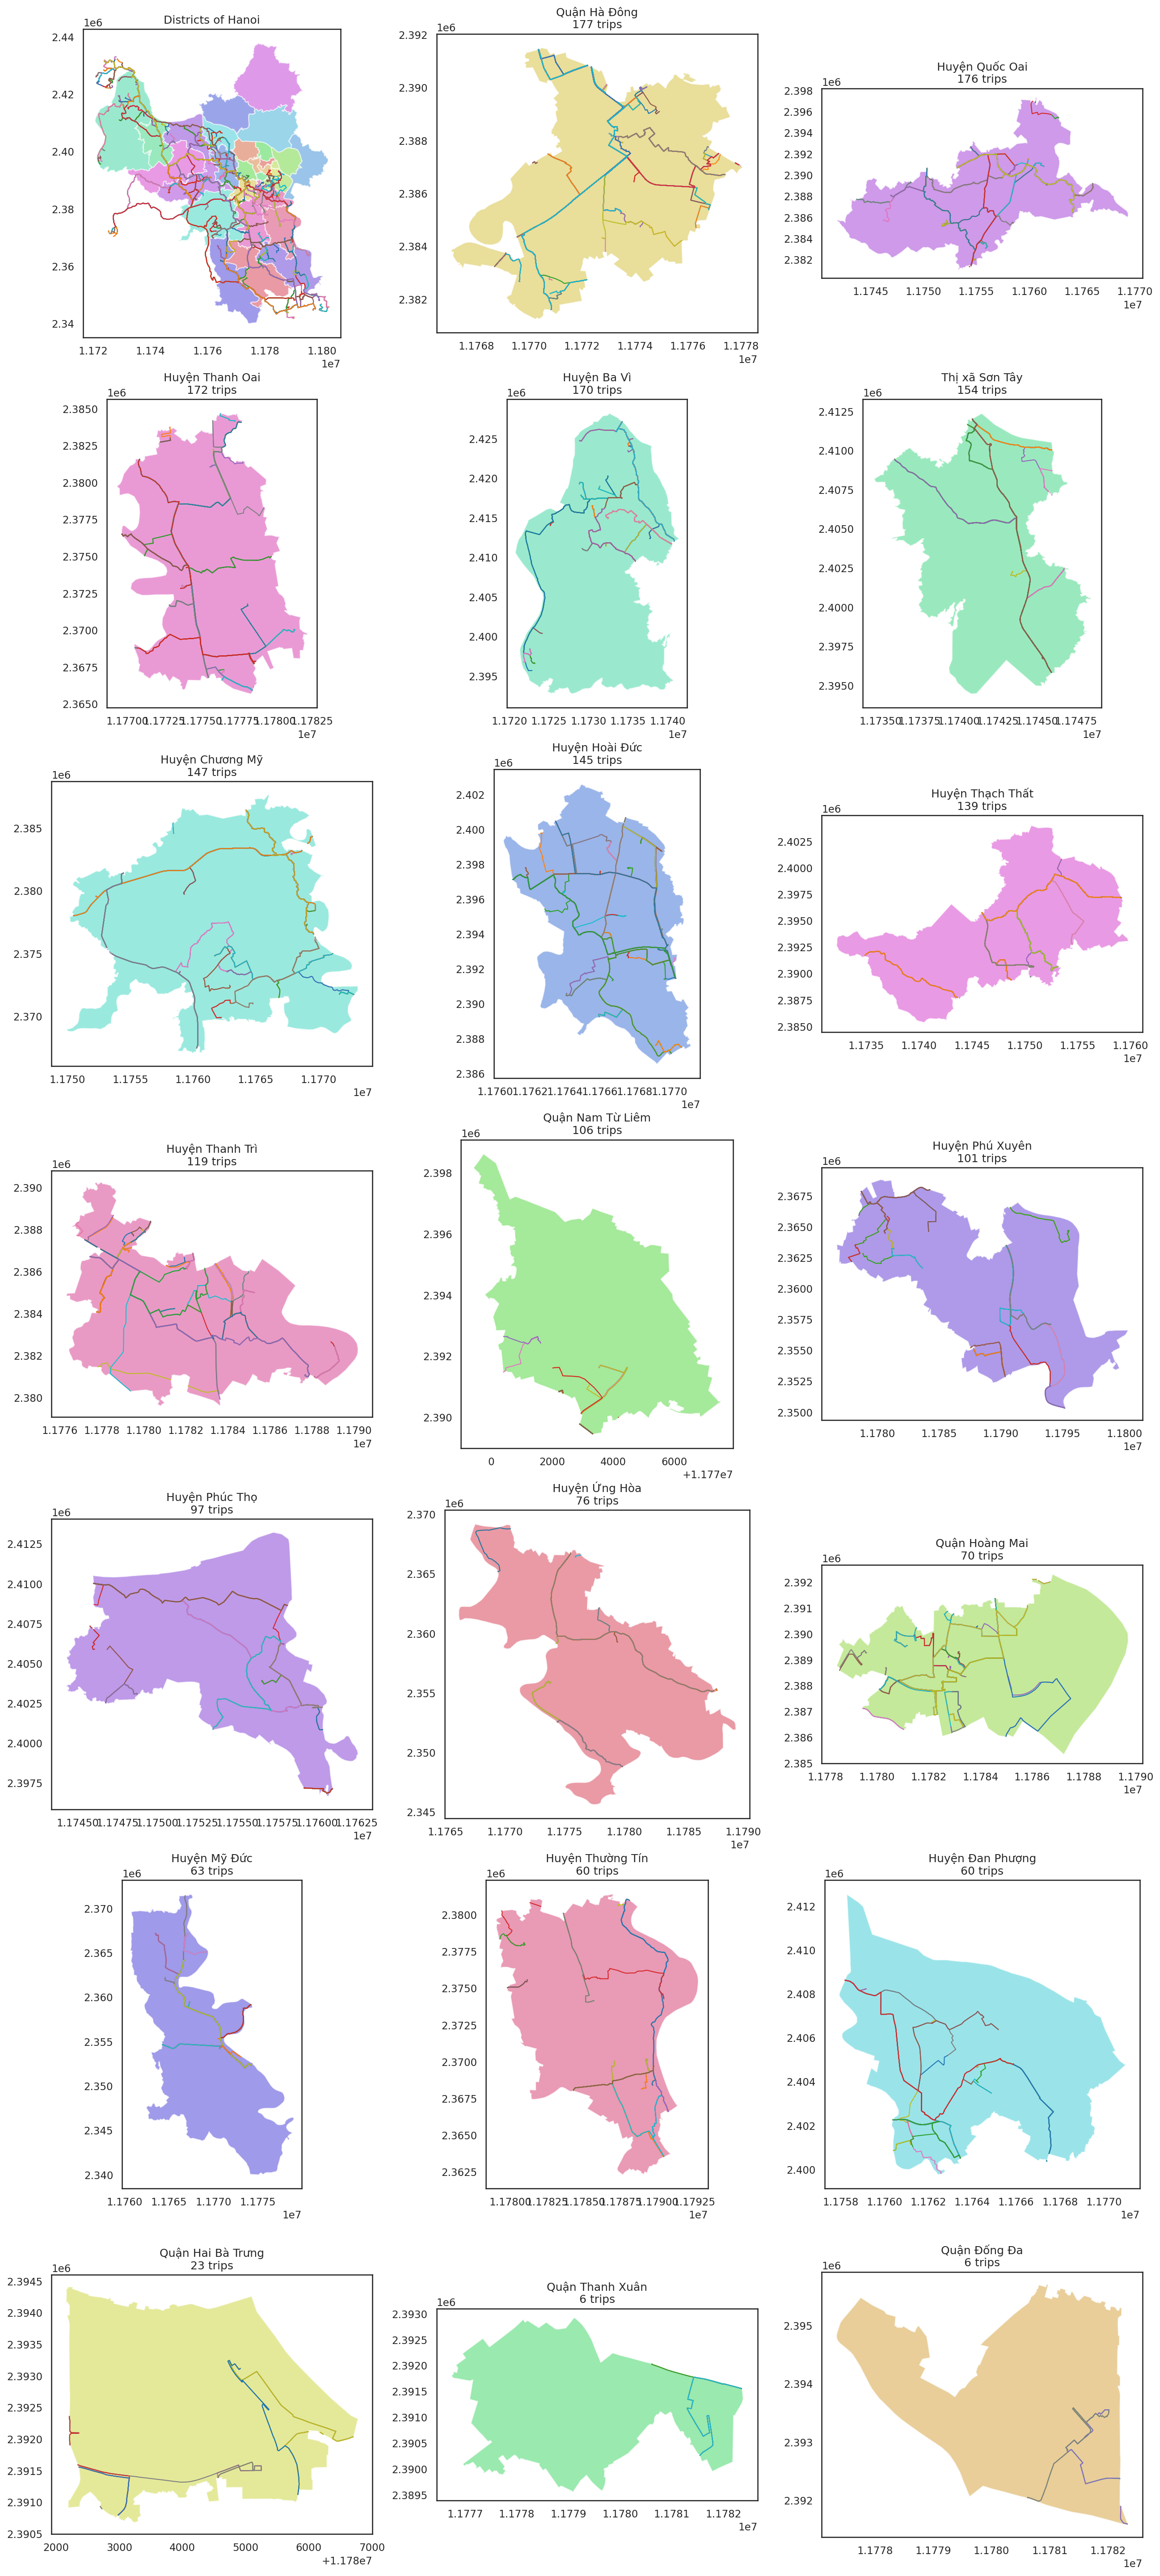

In [41]:
num_rows = 7
num_cols = 3
graph_unit = 7

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * graph_unit, num_rows * graph_unit), dpi=150)

hanoi_gdf.plot(color=hanoi_gdf["color"], ax=axes[0][0], alpha=0.6)
all_trips_gdf.plot(ax=axes[0][0], color=all_trips_gdf['color'], linewidth=1)
axes[0][0].set_title("Districts of Hanoi")

for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j - 1
        if idx >= 0:
            ax = axes[i][j]
            district_name = district_count_df.iloc[idx]['municipalityname']
            trip_count = district_count_df.iloc[idx]['intersect_count']
            district_geom_gdf = hanoi_gdf[hanoi_gdf['municipalityname'] == district_name]
            district_geom_gdf.plot(ax=ax, color=district_geom_gdf["color"], alpha=0.6)
            district_trips_gdf = get_district_trips(district_name)
            district_trips_gdf['color'] = get_trip_colors(district_trips_gdf.shape[0])
            district_trips_gdf.plot(ax=ax, color=district_trips_gdf['color'], linewidth=1)
            ax.set_title(f'{district_name}\n{trip_count} trips')

plt.show()

Top 6 districts with the most trips crossing them:

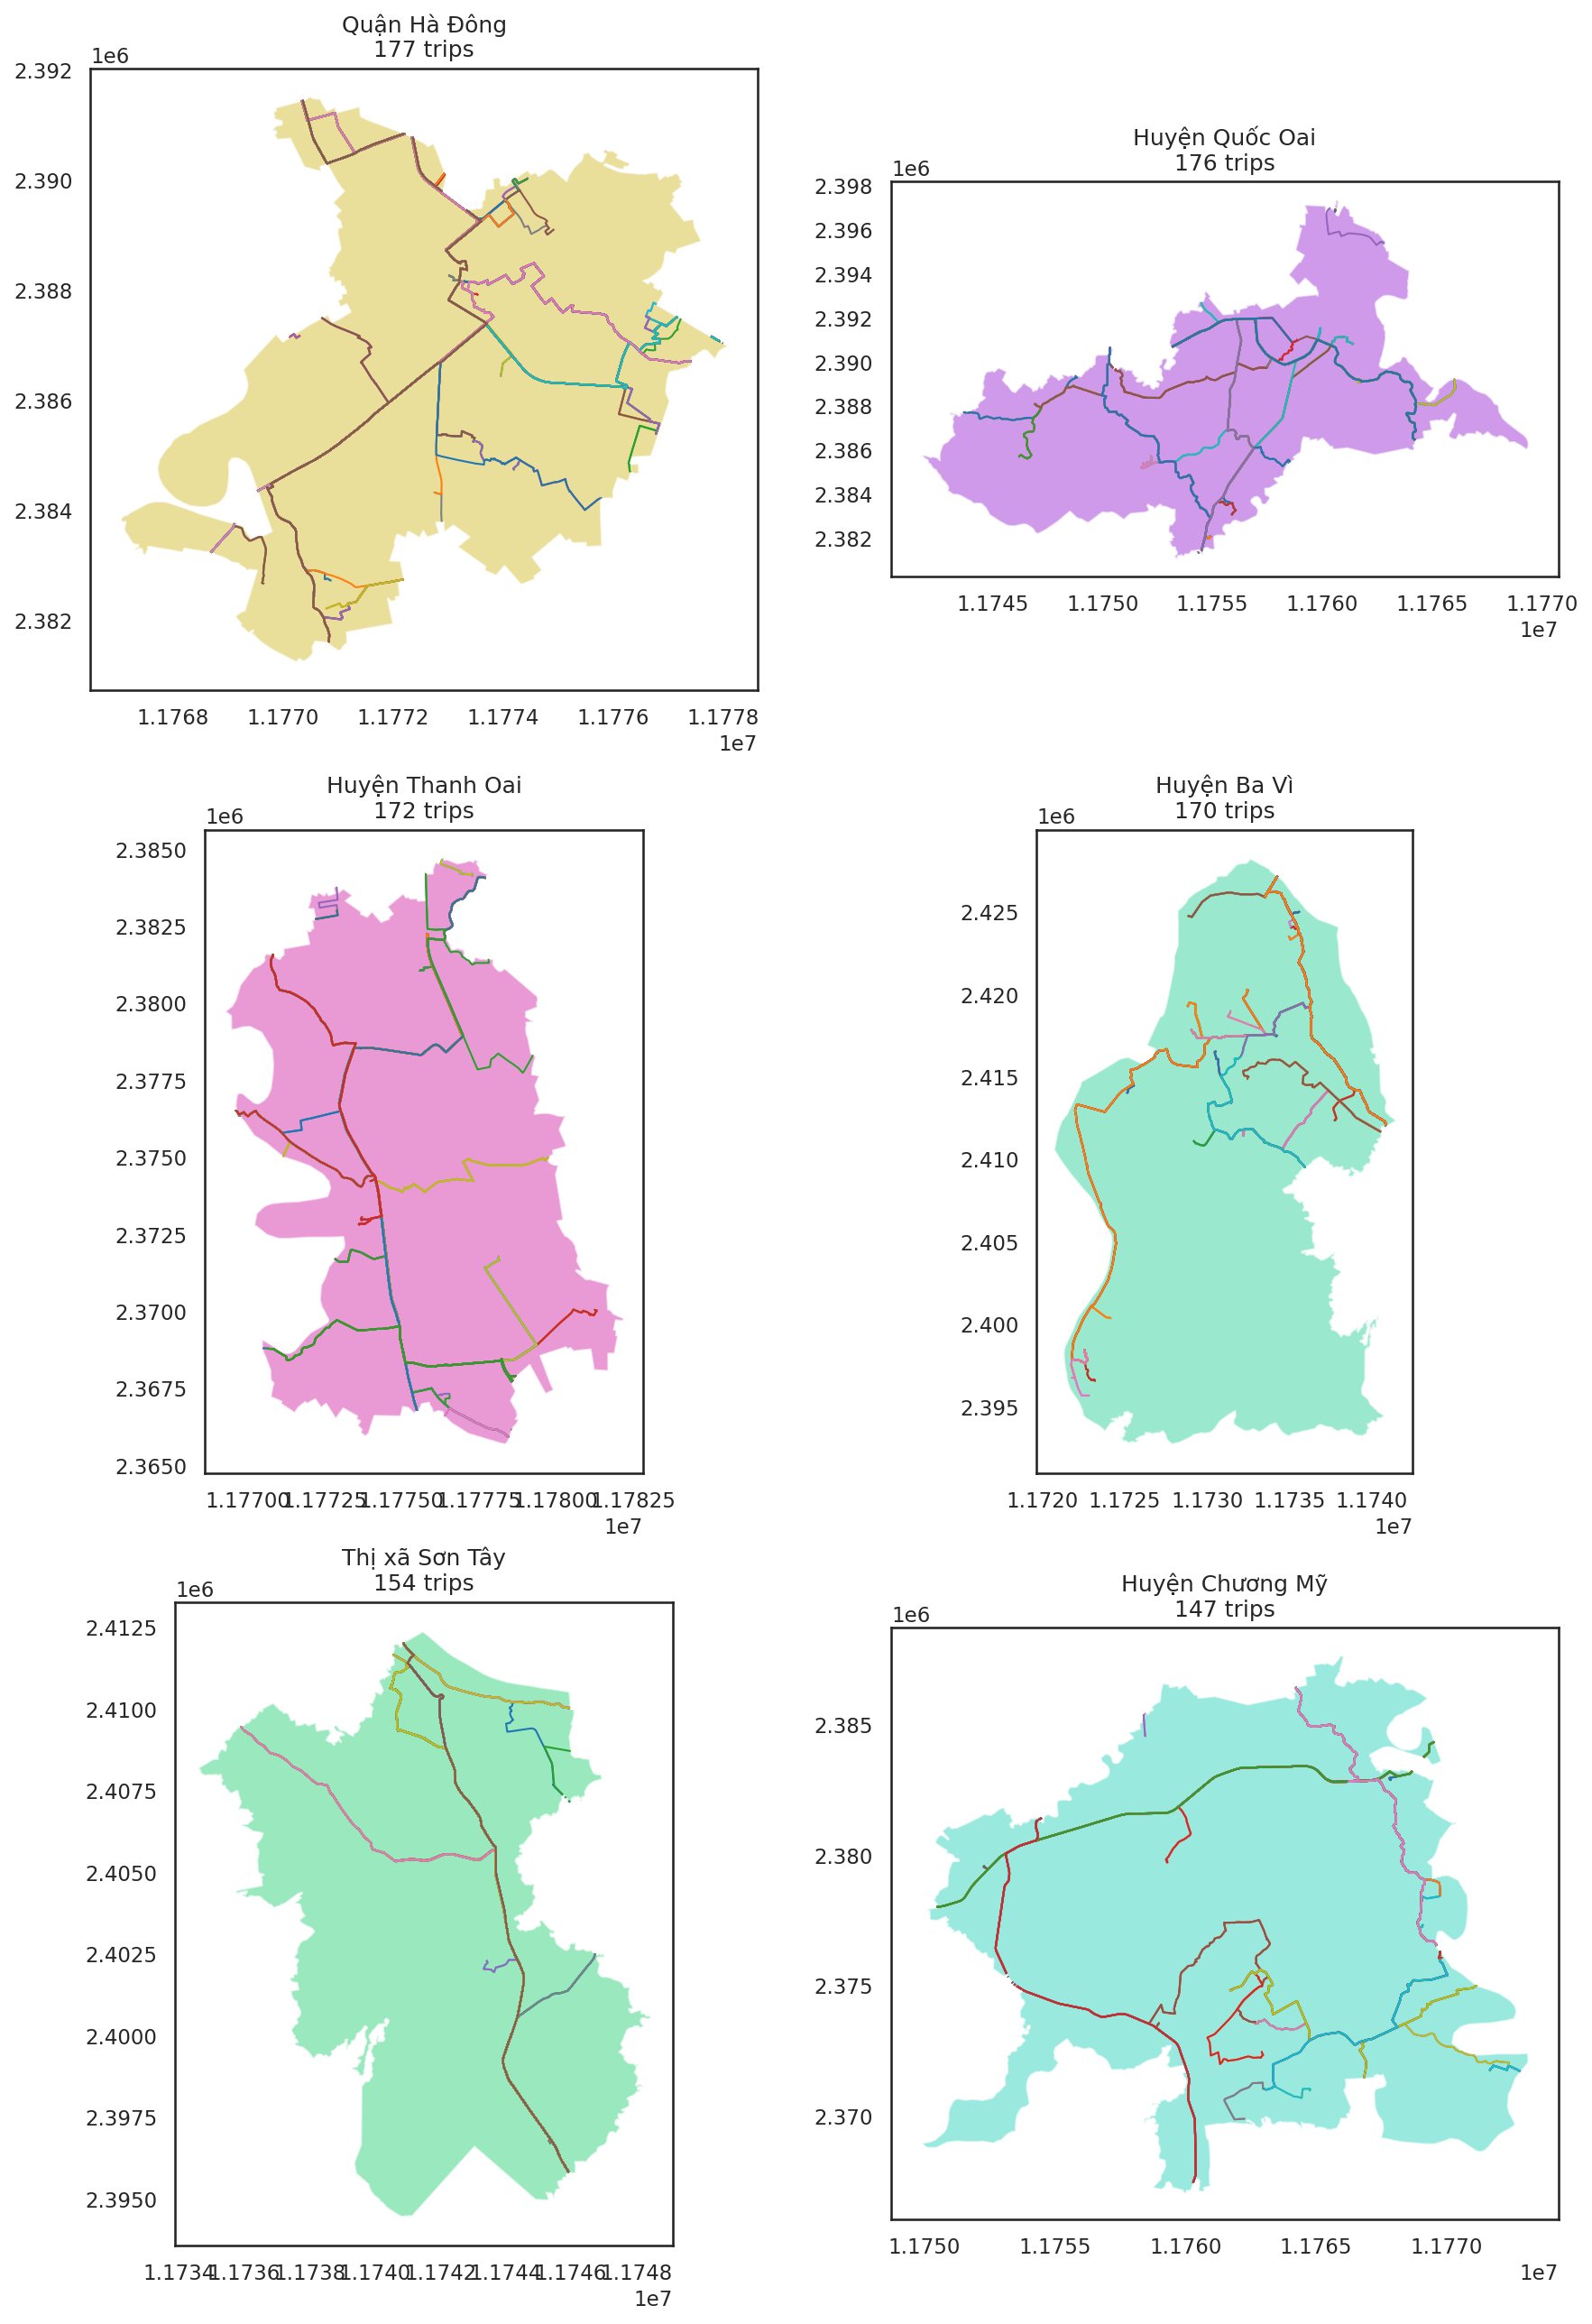

In [73]:
num_rows = 3
num_cols = 2
graph_unit = 7

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * graph_unit, num_rows * graph_unit), dpi=150)

for i in range(num_rows):
    for j in range(num_cols):
        idx = i * num_cols + j
        if idx >= 0:
            ax = axes[i][j]
            district_name = district_count_df.iloc[idx]['municipalityname']
            trip_count = district_count_df.iloc[idx]['intersect_count']
            district_geom_gdf = hanoi_gdf[hanoi_gdf['municipalityname'] == district_name]
            district_geom_gdf.plot(ax=ax, color=district_geom_gdf["color"], alpha=0.6)
            district_trips_gdf = get_district_trips(district_name)
            district_trips_gdf['color'] = get_trip_colors(district_trips_gdf.shape[0])
            district_trips_gdf.plot(ax=ax, color=district_trips_gdf['color'], linewidth=1)
            ax.set_title(f'{district_name}\n{trip_count} trips')

plt.show()

## Total distance traveled per district

In [43]:
query = """
SELECT h.municipalityname, round(
    (sum(
        length(atGeometry(t.trip, h.geom::WKB_BLOB))
    ) / 1000)::numeric, 3
) AS total_km
FROM trajectories t, hanoi h
WHERE ST_Intersects(t.traj, h.geom)
GROUP BY h.municipalityname;
"""

district_km_df = connection.execute(query).df()
district_km_df.head()

municipalityname  total_km
0   Huyện Hoài Đức  1758.906
1   Thị xã Sơn Tây  2430.924
2     Quận Hà Đông  1720.483
3  Huyện Phú Xuyên   768.278
4  Huyện Thanh Trì   707.062

In [44]:
district_km_gdf = hanoi_gdf.merge(district_km_df, left_on='municipalityname', right_on='municipalityname', how='left')
district_km_gdf.head(2)

municipalityid  municipalityname  population  percpop  popdensitykm2  \
0               1      Quận Ba Đình      223100     0.03          24224   
1               2  Quận Bắc Từ Liêm      359200     0.04           7938   

   noenterp  percenterp                                    municipalitygeo  \
0      3981        0.03  0103000020110F0000010000009601000055AD2419DB76...   
1      6409        0.05  0103000020110F0000010000003A01000049B8A0504872...   

                                                geom  \
0  [2, 4, 0, 0, 0, 0, 0, 0, 216, 182, 51, 75, 213...   
1  [2, 4, 0, 0, 0, 0, 0, 0, 66, 146, 51, 75, 221,...   

                                            geom_obj    color  total_km  
0  POLYGON ((11777752.786 2395483.963, 11777961.3...  #db5f57       NaN  
1  POLYGON ((11768386.52 2400374.69, 11768448.424...  #db7957       NaN

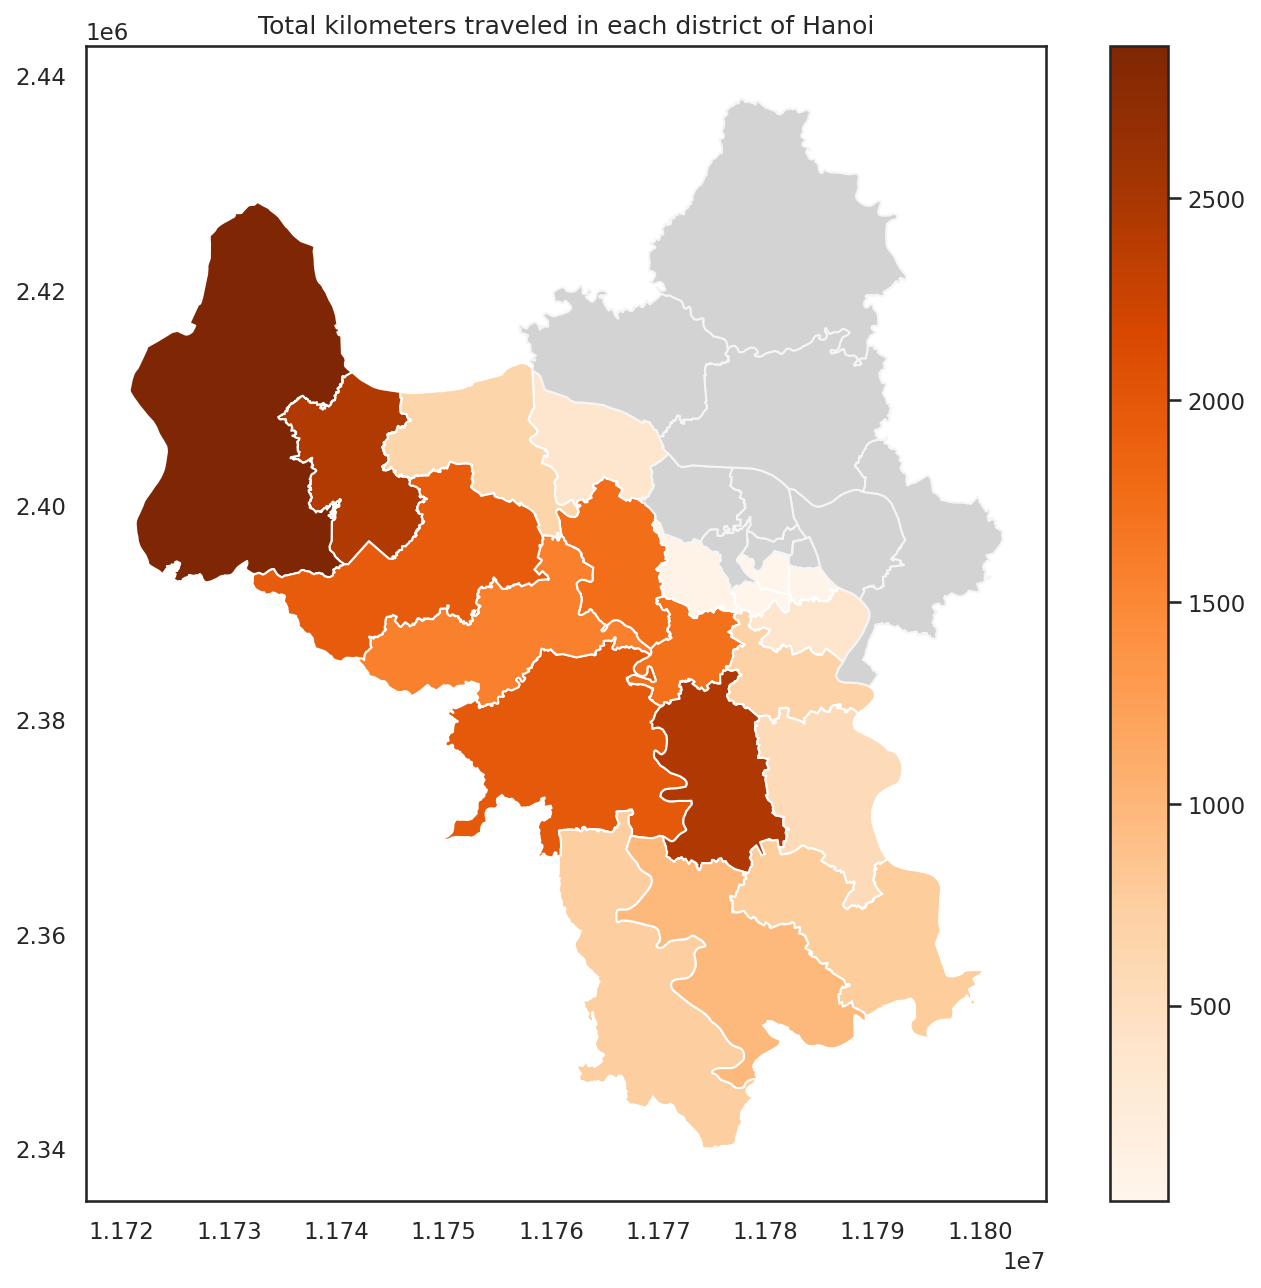

In [75]:
_, axes = plt.subplots(figsize=(10, 10), dpi=150)
district_km_gdf.plot(column='total_km', ax=axes, legend=True, cmap='Oranges',
                     missing_kwds={
                        "color": "lightgrey",
                        "edgecolor": "whitesmoke"
                    })
axes.set_title('Total kilometers traveled in each district of Hanoi')
plt.show()